# Project Text Mining
Cong Anh Khanh LE, Lawan DAN AZOUMI, Julien NIQUE

février 2021

# I. Introduction
L'objectif général de ce projet est de comprendre la structure d'un corpus d'articles scientifiques à partir de plusieurs modèles de représentation des documents (bag of words, plongements vectoriels, modélisation thématique) et d'outils d'analyse et de visualisation liés à ces modèles (Clustering, nuages de mots, thématiques). Un prolongement sur la recherche de documents et d'auteurs est proposé à la fin de ce notebook. 

# Implémentation
---
Dans cette première partie, nous chargeons les données, un corpus de plus de 60 000 articles scientifiques puis, après une étape de préprocessing, nous construisons les représentations vectorielles des documents selon plusieurs approches. 

## Packages utilisés
Les packages utilisés dans ce notebook sont :
- numpy, pandas, sklearn
- wordcloud, nltk
-  gensim, umap, pyvis

In [ ]:
pip install umap-learn[plot]


     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 17.1 MB/s 
     |████████████████████████████████| 15.8 MB 35.9 MB/s 
     |████████████████████████████████| 76 kB 1.9 MB/s 
     |████████████████████████████████| 136 kB 35.3 MB/s 
     |████████████████████████████████| 837 kB 19.2 MB/s 
     |████████████████████████████████| 830 kB 34.8 MB/s 
     |████████████████████████████████| 822 kB 17.8 MB/s 
     |████████████████████████████████| 802 kB 11.4 MB/s 
     |████████████████████████████████| 802 kB 38.6 MB/s 
     |████████████████████████████████| 793 kB 36.8 MB/s 
     |████████████████████████████████| 793 kB 11.2 MB/s 
     |████████████████████████████████| 791 kB 37.9 MB/s 
     |████████████████████████████████| 786 kB 46.8 MB/s 
     |████████████████████████████████| 779 kB 30.0 MB/s 
     |████████████████████████████████| 778 kB 48.3 MB/s 
     |████████████████████████████████| 776 kB 40.1 MB/s 
     |███████████

In [ ]:
!pip install pyLDAvis


     |████████████████████████████████| 1.7 MB 12.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9cd06aa2b488c752f1b183f1bb89f413d7b0b4ffb473ab4580c03bb6f5e5a533
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
!pip install pyvis

  Created wheel for pyvis: filename=pyvis-0.2.0-py3-none-any.whl size=23677 sha256=bfc8f9fae27d8c66f41175b44c9a414336a4d9ad625f2fdfc8f9b33e2fb082f6
  Stored in directory: /root/.cache/pip/wheels/74/ed/a1/9441bf0a9e35efc8351ea92cb62c71c2a604a027b890f970c4
Successfully built pyvis


In [ ]:
#chargement des librairies
#pip install umap-learn[plot]

from random import sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

!python -m spacy download fr_core_news_md
import spacy
import fr_core_news_md
nlp = fr_core_news_md.load()

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics.pairwise import cosine_similarity
from nltk.collocations import *
import umap
import umap.plot

import pyLDAvis
#import pyLDAvis.gensim 
from pyvis.network import Network


     |████████████████████████████████| 88.6 MB 7.0 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=3044ec78db63f94890175254e5844c21dcb9d15217ab28ce7fb477f427729406
  Stored in directory: /tmp/pip-ephem-wheel-cache-esyxr9hw/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


ModuleNotFoundError: ignored

## 2. Loading data
Le jeu de données utilisé vient du Citation Network Dataset qui rassemble plusieurs millions d’articles : https://www.aminer.org/citation. Nous utilisons en particulier le jeu de données fourni durant le cours qui est tiré de la version 10 et comprend 64290 articles. 
Le corpus d'articles est initialement au format json. Nous utilisons la librairie pandas pour transformer les données en un dataframe contenant notamment les attributs : auteur, titre et résumé de l'article.
Pour faciliter le traitement, le jeu de données est filtré en ne conservant que les articles qui contiennent à la fois un titre et un résumé non vides. Après la filtration, le jeu de données contient 25331 articles. Puis, nous concatenons le titre et le résumé pour avoir le corpus que nous allons utiliser dans ce projet.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#chargement des données au format json stockées dans le dossier "content/sample_data et conversion en dataframe"
df = pd.read_json("/content/drive/MyDrive/Colab Notebooks/dblp-extrait.json", dtype='Object', lines=True)
#df = pd.read_json("sample_data/dblp-extrait.json", dtype='Object', lines=True)
# éliminer les articles dont le résumé ou le titre est manqué.
df = df[df['abstract'].notnull()]
df = df[df['title'].notnull()]

#ajout d'une colonne data qui est une concatenation du titre et du résumé.
df['data'] = (df.abstract + df.title).values

#nombre de documents dans le corpus
print('Il y a %i références dans le corpus.' % df.shape[0])
data = df[['data']].iloc[0:5000]['data']

## 3. Prétraitement
---
Pour assurer une bonne analyse, le texte a besoins d'être prétraité.
On fait les prétraitements basiques suivants:
* lower case
* supprimer le stop words
* supprimer les mots trop fréquents
* supprimer les mots trop rares
* stemming
* fixer le taille de vocabulaire à 2000 tokens

Tous ces prétraitments peuvent être inclus dans la construction de le matrice Documents-Termes par CountVerterizer dans sklearn.feature_extraction.text.

En effet, CountVerterizer génère la matrice Documents-Termes à partir du texte en incluant les prétaitements.Après, la fonction inverse_transform permet de regénerer la liste des tokens prétraités.

In [ ]:
## including stemming
stemmer_en = SnowballStemmer("english")
analyzer = CountVectorizer().build_analyzer()
def stemmed_words_en(doc):
    return (stemmer_en.stem(w) for w in analyzer(doc))
#création de la matrice tf avec prétraitement (stemming)
tf_vectorizer_stem = CountVectorizer(stop_words="english", max_df=0.3, min_df=2, max_features=2000, analyzer=stemmed_words_en)
# matrix Document-termes
doc_vec_stem_tf = tf_vectorizer_stem.fit_transform(data).toarray()
# number of documents, number of terms
ndocs_stem, nterms_stem = doc_vec_stem_tf.shape
# features
features_stem_tf = tf_vectorizer_stem.get_feature_names()
print("Taille du vocabulaire avec stemming : {}".format(nterms_stem))
# Invert_transform le matrice document-termes pour obtenir le text prétraité.
processed_doc_stem_array = tf_vectorizer_stem.inverse_transform(doc_vec_stem_tf)
processed_doc_stem = [" ".join(text) for text in processed_doc_stem_array]

Taille du vocabulaire avec stemming : 2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 4. Représentations vectorielles des documents

### 4.1. Espace de mots
----
Les approches de type bag of words ne tiennent pas compte de l'ordre des mots. Nous pouvons modéliser par exemple le corpus en :
- une matrice tf ("term frequency") où chaque ligne correspond à un document et où chaque colonne identifie un mot du vocabulaire. A leur intersection, on note le nombre de fois que le mot apparaît dans le document.
- une matrice tfidf où l'on multiplie les effectifs précédents par la fréquence inverse du document, qui vise à donner un poids plus important aux termes les moins fréquents, considérés comme plus discriminants.

#### 4.1.1. Approche tf 
La matrice Documents x Termes a été obtenue dans l'étape précedente de prétraitement.


In [ ]:
## including stemming
# matrice Document-termes tf
doc_vec_stem_tf
# feature tf
features_stem_tf

['10',
 '100',
 '11',
 '12',
 '13',
 '15',
 '16',
 '20',
 '2005',
 '2006',
 '2008',
 '2010',
 '2011',
 '2d',
 '30',
 '3d',
 '40',
 '802',
 'abil',
 'abl',
 'abnorm',
 'about',
 'abov',
 'abstract',
 'academ',
 'acceler',
 'accept',
 'access',
 'accomplish',
 'accord',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'achiev',
 'acoust',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'actuat',
 'ad',
 'adapt',
 'add',
 'addit',
 'address',
 'adequ',
 'adjust',
 'administr',
 'adopt',
 'adult',
 'advanc',
 'advantag',
 'adversari',
 'advertis',
 'affect',
 'affin',
 'afford',
 'after',
 'against',
 'age',
 'agent',
 'aggreg',
 'agil',
 'agreement',
 'agricultur',
 'ai',
 'aid',
 'aim',
 'al',
 'alarm',
 'alert',
 'algebra',
 'algorithm',
 'align',
 'all',
 'alloc',
 'allow',
 'almost',
 'alon',
 'along',
 'alphabet',
 'alreadi',
 'also',
 'altern',
 'although',
 'alway',
 'ambigu',
 'among',
 'amount',
 'analog',
 'analys',
 'analysi',
 'analyt',
 'a

#### 4.1.2. Approche tfidf
La matrice Documents x Termes a été obtenue dans l'étape précedente de prétraitement.

In [ ]:
## including stemming
tfidf_vectorizer_stem = TfidfVectorizer()
# matrice Document-termes
doc_vec_stem_tfidf = tfidf_vectorizer_stem.fit_transform(processed_doc_stem).toarray()
# features
features_stem_tf = tfidf_vectorizer_stem.get_feature_names()



### 4.2. Espaces de plongement 

#### 4.2.1. Espace de plongement "naïf"
Dans cette approche, chaque document est représenté par un vecteur égal à la moyenne des vecteurs de tous les mots de ce document, ceux-ci étant chargés à partir de la librairie spacy.

In [ ]:
# On récupère la taille des plongements car elle constitue la dimension de l'espace dans lequel on va plonger les documents.

dim = len (nlp.vocab.vectors[nlp.vocab.strings[str("word")]])

def centre(d):
    """
    Get the representation vector for a given document d by averaging the representation vector of all words in the document 
    """
    m = np.zeros(shape=(1,dim))
    nbw = 0
    for w in d:
        try:
            v = nlp.vocab.vectors[nlp.vocab.strings[str(w)]]
            m = np.append(m, v.reshape((1,dim)), axis=0)     
            nbw += 1
        except:
            pass
    seuil = True
    if nbw>0:
        return (nbw, np.sum(m, axis=0)/nbw) # la normalisation est inutile si on utilise le cosinus
    else:
        return (0, m)
#Puis on calcule la représentation pour chaque document du corpus. 

i = 0
doc_vec_stem_naif = np.zeros(shape=(ndocs_stem,dim))
id_docs_nonvides = []
for d in processed_doc_stem_array:
    nbw, r = centre(d)
    doc_vec_stem_naif[i] = r.reshape((1,dim))
    i += 1


NameError: ignored

#### 4.2.2. Représentations vectorielles avec Doc2Vec
Ici l'espace vectoriel de représentation des documents est obtenu à partir de l'algorithme Doc2Vec, qui est une extension de Word2Vec. Nous choisissons une dimension égale à 100.

In [ ]:
# on rajoute une taille minimale
min_tokens = 3
tagged_docs = []
#dimension de l'espace de représentation : 100
dim_d2v = 100
for i, list_tokens in enumerate(processed_doc_stem_array):
    if len(list_tokens) > min_tokens:
        tagged_docs.append(TaggedDocument(words=list_tokens, tags=[str(i+1)]))

model_doc2vec_stem = Doc2Vec(tagged_docs, vector_size=dim_d2v, window = 5, step =10, alpha= 0.025, epoch = 1000, dm=0)
model_doc2vec_stem.random.seed(0)
doc_vec_doc2vec_stem = np.zeros(shape=(ndocs_stem, dim_d2v))
set_tags = list(model_doc2vec_stem.docvecs.doctags)

i = 0
for t in set_tags:
    doc_vec_doc2vec_stem[i] = model_doc2vec_stem.docvecs[t]
    i += 1

### 4.3. Espace thématique LDA
Ici on construit la matrice Documents-Thématiques. Le nombre de lignes correspond au nombre de documents et le nombre de colonnes correspond au nombre des thématiques.
Chaque document est donc représenter par un vecteur de fréquence de thématiques.

Dans ce projet pour contruire le matrice Document-Thématique, nous avons utilisé la méthode topic modelling LDA. L'implémentation de cette méthode se détaille dans le suivant. A partir de maintenant, pour faciliter la reconnaissance des méthodes de représentation, nous allons appeller cette méthode de représentation "LDA".

Pour le faire, il est nécessaire de déterminer le nombre de topics.

#### Recherche du nombre optimal de thématiques
----
L'approche pour trouver le nombre optimal de sujets est de construire de nombreux modèles LDA avec différentes valeurs de nombre de sujets (k) et de choisir celui qui donne la valeur de cohérence la plus élevée.
Le choix d'un «k» qui marque la fin d'une croissance rapide de la cohérence des sujets offre généralement des sujets significatifs et interprétables. Choisir une valeur encore plus élevée peut parfois fournir des sous-sujets plus granulaires.

Référence: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# création du dictionnaire
id2word_stem = corpora.Dictionary(processed_doc_stem_array)
# Create Corpus
texts = processed_doc_stem_array

# matrice Term Document Frequency
corpus_stem = [id2word_stem.doc2bow(text) for text in texts]

coh_list = []
coherence_values_stem = []
model_list_stem = []
for num_topic in range(2, 22, 4 ):
    model = LdaModel(corpus=corpus_stem,
                       id2word=id2word_stem,
                       num_topics=num_topic, 
                       random_state=100,
                       update_every=1,
                       chunksize=100,
                       passes=10,
                       alpha='auto',
                       per_word_topics=True)
    model_list_stem.append(model)
    coherencemodel_stem = CoherenceModel(model=model, texts=texts, dictionary=id2word_stem, coherence='c_v')
    coherence_values_stem.append(coherencemodel_stem.get_coherence())



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin ins

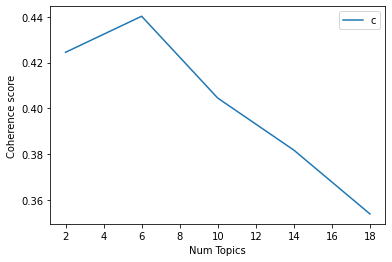

In [ ]:
# Show graph
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values_stem)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Nous pouvons observé un seul maximum local à k=6. Par conséquent, on va choisir k= 6 pour déterminer le vecteur de représentation

#### Obternir le représentation vectorielle

In [ ]:
# obtain document vector
num_topics=6
lda_model_stem = model_list_stem[1]
doc_vec_LDA_stem = np.zeros(shape=(ndocs_stem,num_topics))
for i, d in enumerate(lda_model_stem[corpus_stem]):
    for j, (topic, poids) in enumerate(d[0]):
        doc_vec_LDA_stem[i, topic] = poids

# 5. Analyse et visuallisation des corpus

## 5.1. Nuage de mots du corpus
On visualise les mots les plus fréquents dans le corpus par un nuage de mots.

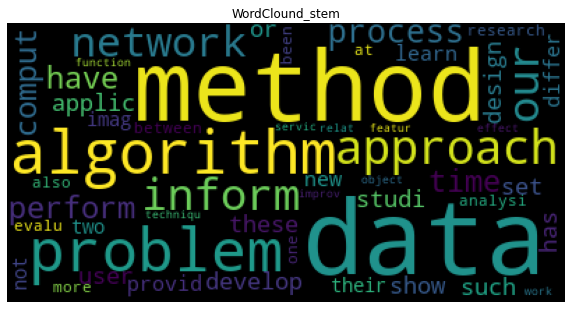

In [ ]:
#les "labels" du nuage sont les mots
cloud_labels_stem = features_stem_tf
#les poids correspondent à la somme des TF selon les lignes de la matrice
cloud_weights_stem = np.sum(doc_vec_stem_tf, axis=0)
#on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
dictionary_stem = dict(zip(cloud_labels_stem, cloud_weights_stem)) # zip "colle" le vecteur des labels au vecteur des poids
#on trie par ordre décroissant
sorted_by_value_stem = sorted(dictionary_stem.items(), key=lambda kv: kv[1], reverse=True)

limit = 50
fontcolor='#fafafa'
bgcolor = '#000000'
wordcloud_stem = WordCloud(max_words=limit, background_color=bgcolor).fit_words(dictionary_stem)


import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 20))
plt.imshow(wordcloud_stem)
plt.title("WordClound_stem")
plt.axis('off')

plt.show()




## 5.2. Co-occurrence de mots du corpus
Ici on voudrait mesurer le score de co-occurrence des mots dans des documents.
Pour le faire, on mesure la similarité de deux vecteurs de deux mots (produit scalaire) obtenus dans la matrice Terms-Documents qui est le transpose du matrix Documents-Termes.
Puis on peut visuliser par un réseau dans lequel chaque neoud est un mot qui est relié avec les mots dont leur score co-occ est supérieur à un seuil qu'on peut fixer. 

In [ ]:
## no stemming tf
X = doc_vec_stem_tf
features = features_stem_tf
# subsample of random numbers of words
index = sample(list(np.arange(0,nterms_stem)),200)
X_small = X[:,index]
features_small = np.array(features)[index]
(_,num_f_small) = X_small.shape
print("Nombre de colonnes = mots : " + str(num_f_small))

# similarité matrice
co_occ = np.matmul(X_small.transpose(), X_small)

# list de mot de source, mot cible et leur score de co-occ
sources = []
targets = []
weights = []
for i in range(num_f_small):
    for j in range(num_f_small):
        if ((i != j) & (co_occ[i, j] > 150)):
                sources = sources + [features_small[i]]
                targets = targets + [features_small[j]]
                weights = weights + [float(co_occ[i, j])]

# on crée des séries de données au format "pandas"
import pandas as pd
sources = pd.Series(sources)
targets = pd.Series(targets)
weights = pd.Series(weights)

# Construire une network de mots dont chaque noed est un mot et le edge stock leur score-co-occ


net = Network(height="400px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# set the physics layout of the network
net.barnes_hut()

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w)

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

net.show_buttons(filter_=['physics'])    
   
net.show("co-occurrences.html")



Nombre de colonnes = mots : 200


## 5.3. Topic modeling : LDA
Dans l'étape embedding nous avons déterminer le nombre de thématiques optimal (k=6) dans le corpus qui nous permet de construire le modèle LDA, et les vecteur de représentation des document.
Dans cet étap, on va analyser plus en détail les thématiques obtenus pour compredre mieux le contenus le structure de corpus.

#### 5.3.1. On va d'aborde regarder le liste des topics 
On peut noter que chaque topics contient une set de mots discriminant. Par example, le premier topic contient des mots qui concerne plutôt  data science (data, algorithm, comput, etc.); le dexième peut être concerner la l'imagérie (image, visual, video, etc); le troisième concerne la recherche et l'éducation (recherche, studi, analys, etc.).

In [ ]:
lda_model_stem.show_topics(num_topics=num_topics,formatted=False)

[(0,
  [('show', 0.018730555),
   ('method', 0.018390292),
   ('perform', 0.015177708),
   ('algorithm', 0.014723782),
   ('problem', 0.014550728),
   ('our', 0.010415867),
   ('time', 0.010101378),
   ('data', 0.009612573),
   ('two', 0.009083042),
   ('compar', 0.008987152)]),
 (1,
  [('simul', 0.029036466),
   ('imag', 0.027551295),
   ('network', 0.02631781),
   ('detect', 0.025165368),
   ('low', 0.018818928),
   ('control', 0.018502288),
   ('high', 0.013276941),
   ('signal', 0.013049322),
   ('track', 0.012104043),
   ('locat', 0.011809477)]),
 (2,
  [('studi', 0.024675485),
   ('research', 0.015809247),
   ('was', 0.01288101),
   ('inform', 0.012618897),
   ('were', 0.0114704985),
   ('analysi', 0.009622075),
   ('their', 0.009532078),
   ('identifi', 0.009102097),
   ('effect', 0.009046568),
   ('evalu', 0.008747873)]),
 (3,
  [('develop', 0.013066704),
   ('provid', 0.012832933),
   ('design', 0.012463519),
   ('has', 0.01216578),
   ('applic', 0.012160998),
   ('have', 0.01

### 5.3.2. Visualisation de la ditribution de thématique
Maintenant on va visuliser la distribution des thématiques avec le package pyLDAvis

In [47]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_list_stem[2], corpus_stem, id2word_stem)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.225856 -0.108351       1        1  25.877508
4     -0.199313  0.089372       2        1  17.957426
8      0.025808 -0.288769       3        1  13.443102
3     -0.130364  0.144752       4        1  12.138287
7     -0.174085 -0.162251       5        1  12.018395
6     -0.080646  0.280899       6        1   7.837986
9      0.148345 -0.091451       7        1   4.405964
5      0.223956 -0.019624       8        1   3.369623
0      0.209687  0.078273       9        1   1.545669
1      0.202468  0.077151      10        1   1.406041, topic_info=           Term         Freq        Total Category  logprob  loglift
257     problem  1290.000000  1290.000000  Default  30.0000  30.0000
396   algorithm  1130.000000  1130.000000  Default  29.0000  29.0000
69    implement   770.000000   770.000000  Default  28.0000  28.0000
20      network   673.000000   673.000000  Default  27.0000  27.0000
76       method  1296.000000  1296.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1507      until    51.331430    52.218068  Topic10  -4.3040   4.2473
1649     hospit    50.815889    51.702489  Topic10  -4.3141   4.2471
914   healthcar    50.532693    51.419251  Topic10  -4.3197   4.2470
1435   efficaci    47.380431    48.267160  Topic10  -4.3841   4.2458
1292     threat    45.229660    46.116316  Topic10  -4.4306   4.2450

[493 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
241       5  0.997331  abstract
627       8  0.996898    access
311       5  0.994849   account
37        4  0.996109  accuraci
772      10  0.986281  acquisit
...     ...       ...       ...
110       5  0.040879      will
1040      8  0.989462  wireless
446       2  0.995331   without
221       4  0.993733      word
34        1  0.999080      work

[733 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 9, 4, 8, 7, 10, 6, 1, 2])

Chaque bulle sur le graphique de gauche représente un sujet. Plus la bulle est grande, plus ce sujet est répandu.

Un bon modèle de sujet aura des bulles assez grandes et non superposées dispersées dans le graphique au lieu d'être regroupées dans un quadrant.

Un modèle avec trop de topics aura généralement de nombreux chevauchements, des bulles de petite taille regroupées dans une région du graphique.

Dans le graphe au-dessus, nous pouvons constaster que les bulles, les taille de bulles sont similaire. Par conséquent, on a un nombre de topics raisonable.

### 5.3.3. Recherche de la thématique dominante
L'une des applications pratiques de la modélisation de sujets est de déterminer le sujet sur lequel porte un document donné.
Pour trouver cela, nous trouvons le numéro de sujet qui a le pourcentage de contribution le plus élevé dans ce document.
La fonction format_topics_sentences () ci-dessous regroupe joliment ces informations dans un tableau présentable.
Le code dessous sont trouvé sur le site: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [48]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_stem, corpus=corpus_stem, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Perc_Contrib,Keywords,Text
0,0,2.0,0.4606,"these, have, their, inform, studi, develop, be...",The purpose of this study is to develop a lear...
1,1,2.0,0.4658,"these, have, their, inform, studi, develop, be...",This paper describes the design and implementa...
2,2,3.0,0.2442,"featur, was, imag, test, measur, were, detect,...",This article applied GARCH model instead AR or...
3,3,2.0,0.4413,"these, have, their, inform, studi, develop, be...",NaN
4,4,4.0,0.3609,"problem, time, comput, one, show, function, tw...",NaN
5,5,2.0,0.4883,"these, have, their, inform, studi, develop, be...",NaN
6,6,3.0,0.2906,"featur, was, imag, test, measur, were, detect,...",NaN
7,7,2.0,0.4603,"these, have, their, inform, studi, develop, be...",NaN
8,8,2.0,0.3303,"these, have, their, inform, studi, develop, be...",NaN
9,9,5.0,0.3074,"user, design, environ, implement, network, sup...",NaN


### 5.3.4. Visualisation par thématique (UMAP)
Maintenant nous allons regarder le corpus par UMAP. Le documents sont colloré en fonction de leur thématiques pricipal.

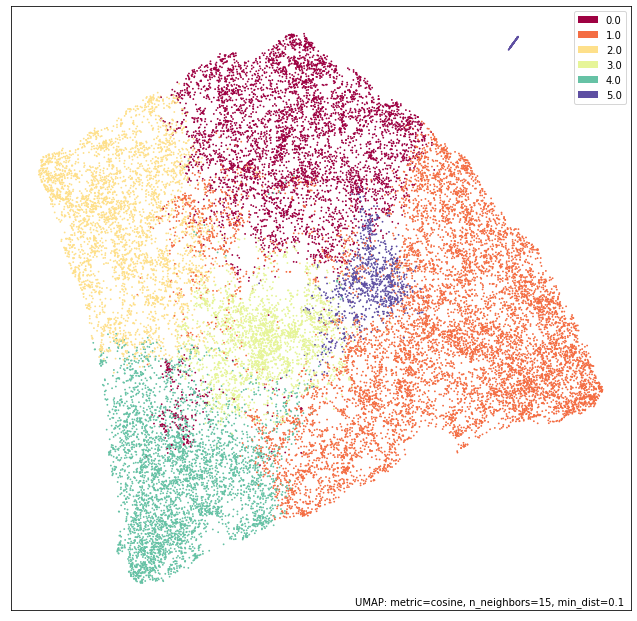

In [ ]:
mapper_lda = umap.UMAP(metric='cosine').fit(doc_vec_LDA_stem)
umap.plot.points(mapper_lda, labels=np.array(df_dominant_topic.Dominant_Topic[:25331]))

hover_data = pd.DataFrame({'index': np.arange(1, ndocs_stem+1),
                           'label': [processed_doc_stem[i] for i in range(ndocs_stem)],
                           'topic': df_dominant_topic.Dominant_Topic[:25331]})
#p = umap.plot.interactive(mapper, labels=id_docs_nonvides, hover_data=hover_data, point_size=2)
#p = umap.plot.interactive(mapper_lda, hover_data=hover_data, point_size=2)
p = umap.plot.interactive(mapper_lda, labels=df_dominant_topic.Dominant_Topic[:25331], hover_data=hover_data, point_size=2)
umap.plot.show(p)

On peut constater que les documents appartenant aux thématiques différentes sont bien répartis dans l'espace de réprésentation.

## 5.4. Clustering
Pour pouvoir compredre mieux le structure du corpus, nous réalisons ici le clustering par le méthode k-mean,  avec des représentations vectorielles obtenues avec Doc2Vec.

### 5.4.1. Recherche graphique du nombre optimal de clusters
On utilise le méthode Elbow pour trouver le nombre de cluster k optimal

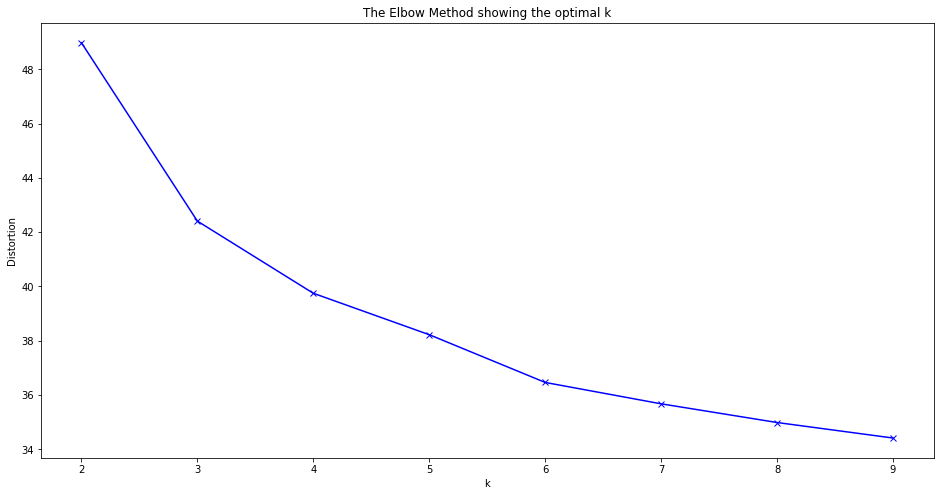

In [ ]:
#doc_vec_matrix_list = [doc_vec_stem_tf, doc_vec_stem_tfidf,doc_vec_stem_naif,doc_vec_doc2vec_stem, doc_vec_LDA_stem]

from sklearn.cluster import KMeans
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(doc_vec_doc2vec_stem)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

On peut observé un coude à k=4, dans la suite nous fixerons un nombre optimal de cluster égal à 4

In [ ]:
k_optimal = 4
km_10_doc2vec = KMeans(n_clusters=k_optimal, random_state=0).fit(doc_vec_doc2vec_stem)
pd.Series(km_10_doc2vec.labels_).value_counts()

0    9294
3    8825
1    6837
2     375
dtype: int64

## 5.4.2. Nuage de mots selons cluster
- Après avoir séparé les documents en cluster, 
- nous allons constituer un nuage de mots en fonction des clusters
- le but étant de présenter les sujets les plus souvent mentionnés dans chaque cluster. 
- On s'apercoit qu'un mot tel que affected apprait le plus souvent dans différents clusters, on peut dire qu'il n'est pas discriminant quant à la répartition des clusters

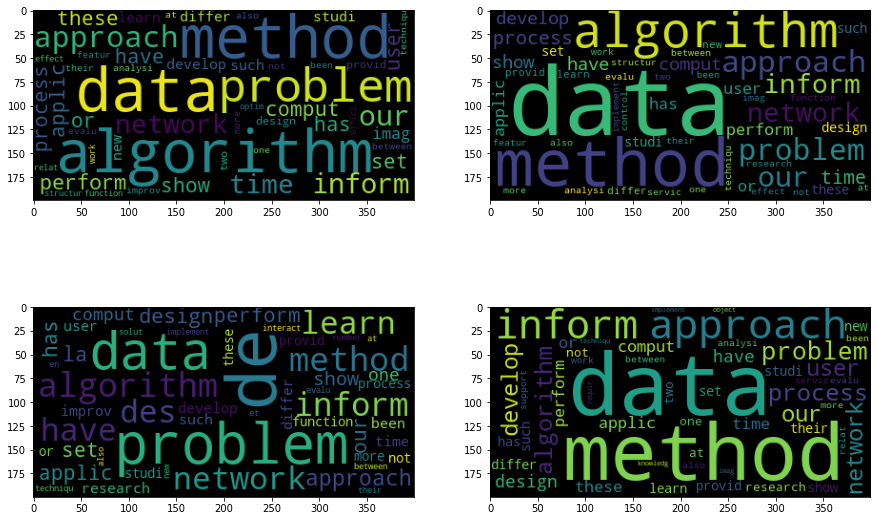

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15, 10), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.09)

axs = axs.ravel()
doc_vec_doc2vec_stem_I = []
for i in range(4):
    a = doc_vec_stem_tf[km_10_doc2vec.labels_ == i, ] # on selectionne les doc_vec_doc2vec_stem correspondants à chaque cluster
    b = pd.DataFrame(data).iloc[km_10_doc2vec.labels_ == i, ] # pareillement pour les documents originaux
    #les "labels" du nuage sont les mots
    cloud_labels = features
    #les poids correspondent à la somme des TF selon les lignes de la matrice
    cloud_weights = np.sum(a, axis=0)
    #on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
    dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
        
    limit = 50
    fontcolor='#fafafa'
    bgcolor = '#000000'
    wordcloud = WordCloud(max_words=limit, background_color=bgcolor).fit_words(dictionary)
    title = "Nuage de mots du corpus"
      
    axs[i].imshow(wordcloud)
    doc_vec_doc2vec_stem_I.append(b)

On constate qu' il exist des mots plus fréquents avec le poids plus important présente dans tous les 4 clusters (data, approche, method). Par contre, les mots les plus discriminant ont le poids moins imporant.

## 5.4.3. Termes fréquents les plus intéressants 
Nous déterminons les terms fréquents les plus intéressants par collocation.

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
nltk.download('punkt')
for i in range(len(doc_vec_doc2vec_stem_I)):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    list_tokens = word_tokenize(" ".join(doc_vec_doc2vec_stem_I[i].squeeze()))

    #On peut faire de même pour les trigrammes, par exemple :
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder_tri = TrigramCollocationFinder.from_words(list_tokens)
    finder_tri.apply_freq_filter(30) # on applique un filtre pour retirer les mots encombrants
    print("###################### ---------------------  ###################### ")
    print("les meilleures colocations du cluster {} sont ".format(i))
    print(finder_tri.nbest(trigram_measures.pmi, 20)[10:])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
###################### ---------------------  ###################### 
les meilleures colocations du cluster 0 sont 
[('[', '5', ']'), ('[', '4', ']'), ('take', 'into', 'account'), ('[', '1', ']'), ('.', 'Index', 'Terms'), ('●', '●', '●'), ('[', '3', ']'), ('[', '2', ']'), ('natural', 'language', 'processing'), ('does', 'not', 'require')]
###################### ---------------------  ###################### 
les meilleures colocations du cluster 1 sont 
[('.', 'Index', 'Terms'), ('[', '1', ']'), ('[', '3', ']'), ('does', 'not', 'require'), ('[', '2', ']'), ('In', 'recent', 'years'), ('Experimental', 'results', 'show'), ('et', 'al', '.'), ('To', 'this', 'end'), ('a', 'wide', 'range')]
###################### ---------------------  ###################### 
les meilleures colocations du cluster 2 sont 
[('.', 'However', ',')]
###################### ---------------------  ############

## 5.4.4. Termes les plus discriminants en pénalisant les termes employés dans trop de catégories 
Nous avons constaté dans les partie avant qu'il existe de mots fréquents qui se présente dans tous les clusters et dont ne sont pas dicriminant. Par conséquent, il est intéressant de les pénaliser pour avoir des termes qui sont plus discriminant.
Notre approche est de determiner le mots appartant à des différent liste de mots le plus fréquents de différent clusters, et les enlever et représenter les mots qui reste dans le nuage de mots. 
Ici on choisi le donnée de doc2vec pour illustrer notre approche.

In [ ]:
most_frequent_word =[]
frequency = []
word_frequency =[]
num = 500
for i in range(4):
    a = doc_vec_stem_tf[km_10_doc2vec.labels_ == i, ] # on selectionne les doc_vec_doc2vec_stem correspondants à chaque cluster
    #les "labels" du nuage sont les mots
    cloud_labels = features
    #les poids correspondent à la somme des TF selon les lignes de la matrice
    cloud_weights = np.sum(a, axis=0)
    #on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
    dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
    #on trie par ordre décroissant
    sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True)
    most_frequent_word.append([word[0] for word in sorted_by_value[:num]])
    frequency.append([word[1] for word in sorted_by_value[:num]])
    word_frequency.append(sorted_by_value[:num])

On determine la fréquence de chaque mots dans la liste extraite. Puis, on determine le mots qui ne se presente que dans un cluster, ces mots sont considéré comme le mots les plus discriminant

In [ ]:
most_frequent_word_join = " ".join([" ".join(text) for text in most_frequent_word])
tf = CountVectorizer()
word_vec = tf.fit_transform(np.array(most_frequent_word_join).reshape(1,)).toarray()[0]
feature_most = tf.get_feature_names()
# liste de mots qui se présente dans un cluster
unique = list(np.array(feature_most)[word_vec<2])

On obtient la liste de mots plus fréquents et plus discriminant et leur fréquence pour chaque clusters basant sur le liste de mots crée avant.
Puis on les visualise sous forme d'un word clound

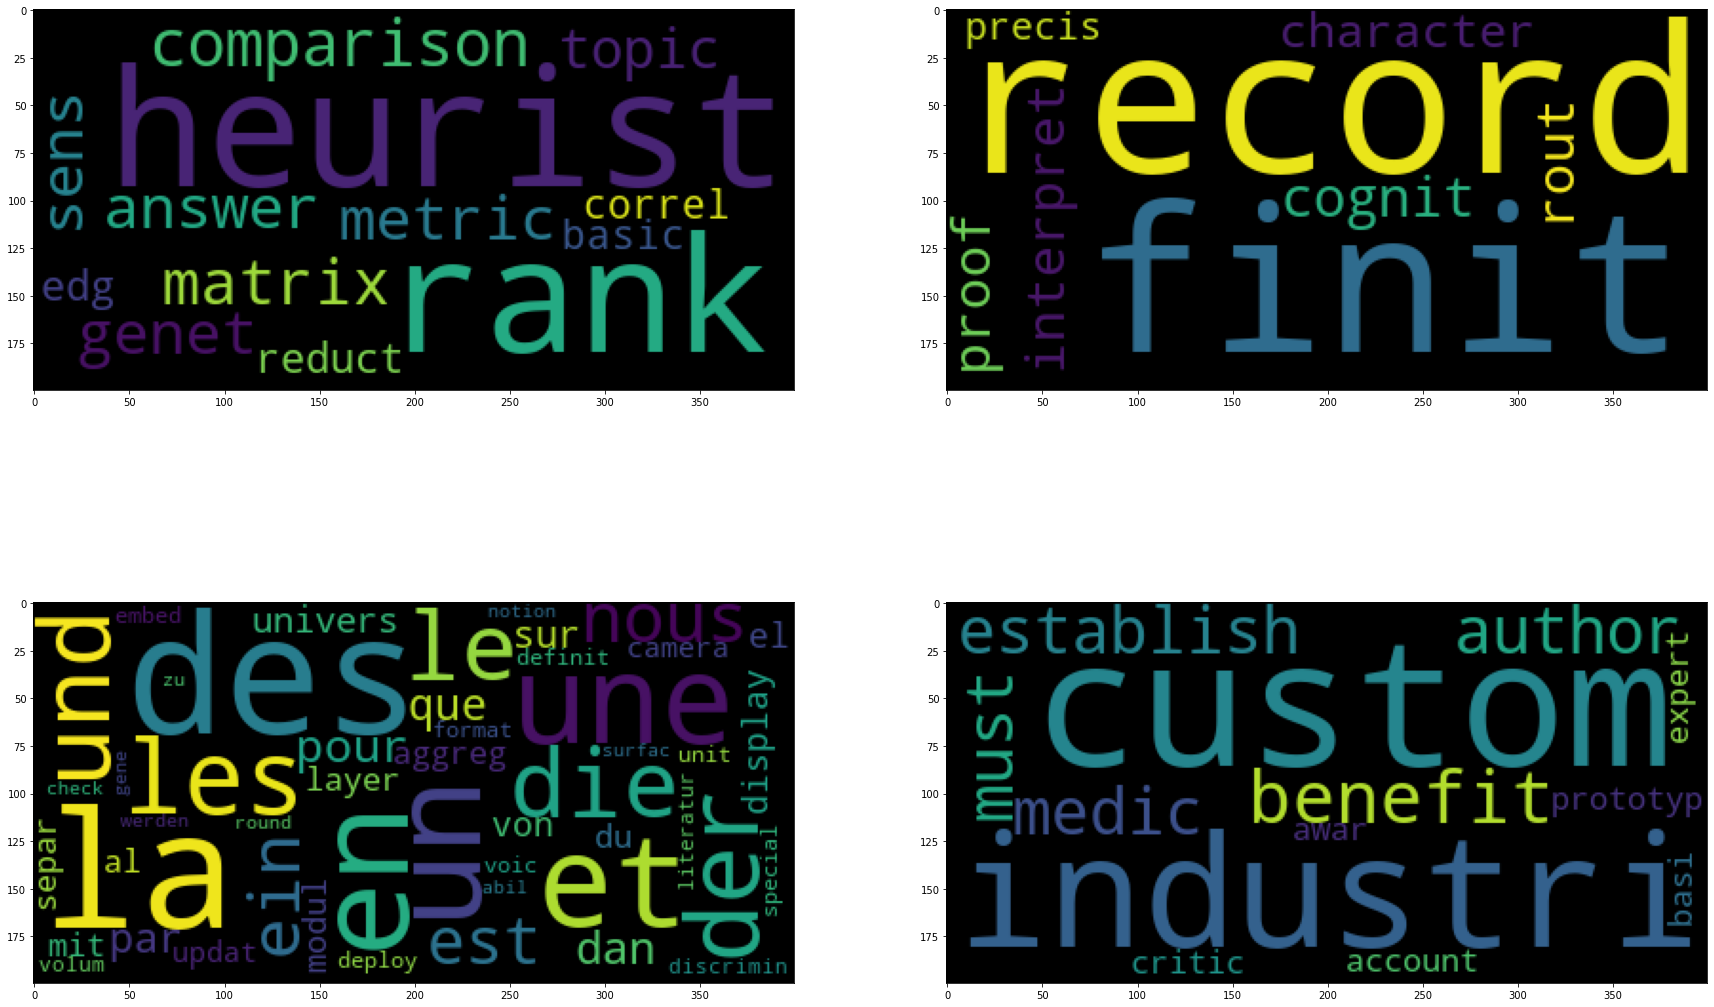

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(30, 20), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.09)
axs = axs.ravel()
for i in range(4):
    wf = [word for word in word_frequency[i] if word[0] in unique ]
    #les "labels" du nuage sont les mots
    cloud_labels = [word[0] for word in wf]
    #les poids correspondent à la somme des TF selon les lignes de la matrice
    cloud_weights = [word[1] for word in wf]
    #on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
    dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
    #on trie par ordre décroissant
    sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True)

    limit = 50
    fontcolor='#fafafa'
    bgcolor = '#000000'
    wordcloud = WordCloud(max_words=limit, background_color=bgcolor).fit_words(dictionary)
    title = "Nuage de mots du corpus"

    axs[i].imshow(wordcloud)

## 5.4.5. Documents les plus centraux à la catégories 
En considérant le centre d'inertie des vecteurs, nous essyons de trouver les documents qui sont proches du centre, en prenant la cosinus entre le vecteur du cluster et le vecteur de documents.

In [ ]:
# vecteur du centre des clusters
km_10_doc2vec.cluster_centers_

# nombre de plus proche documents à trouver
n=5
for i in range(k_optimal):
    # vecteur du centre des clusters
    doc_vec = km_10_doc2vec.cluster_centers_[i]
    # compute la cosinus entre le vecteur du centre avec les vecteur de documents
    s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_doc2vec_stem).reshape(-1,)
    # sort dans l'ordre décroissant
    sorted_ids = np.argsort(-s)
    # choisir les 5 doccument avec les plus grande valeur cosinus
    doc_id = sorted_ids[:n]
    print("les 5 documents les plus proches du cluster ", i, "sont : ", doc_id)
    

les 5 documents les plus proches du cluster  0 sont :  [19059 25231 24962  8234 22998]
les 5 documents les plus proches du cluster  1 sont :  [ 8056 23293 14709 15763 17492]
les 5 documents les plus proches du cluster  2 sont :  [23095 15771 24541 17458  8290]
les 5 documents les plus proches du cluster  3 sont :  [24541 15771  3579  8483 18208]


# 6. Moteurs de recherche

## 6.1. Recherche les documents les plus similaire avec un document donné.
La similarité entre deux documents peut être évaluée par le cosinus entre leurs vecteurs de représentation. On mesure d'abord le cosinus entre le vecteur du document donné avec les vecteurs de tous les documents disponibles. Si le document en entrée est donné sous format de chaine, le vecteur de représentation sera calculé selon le méthode d'embedding donnée. Après avoir tous les cosinus, on trie ces scores dans l'ordre decroissant, ce qui nous permets de déterminer les vecteurs les plus similaires (pour les scores les plus élevés).

In [ ]:
# find the author of a given abstract by comparing the presentation vector of the abstract with
# the prepresentation vectors of all authors. The similarity can be evaluated through the cosinus of the two vector
def find_nearest_document(doc_vec,  n=5,  embedding='tf'):
    '''
    Compute the cosinus between the vector of an given document and that of all available documents.
    Params:
    doc_vec: str, raw document ; or a vector of document.
    n: int or None, number of document ids with highest cosinus values to be returned. If None, all document ids and correspoding with be returned. Default is 10
    embedding: embedding method. Possible values is: "tf", "tfidf", "naif", "doc2vec", "LDA". Default is tf.
    Return:
    A dictionnary with ids of the most closed doccument and the corresponding cosinus values in a descending order.
    '''
  
    if (embedding == 'tf'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            doc_vec = tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray()
        s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_stem_tf).reshape(-1,)
       
    if (embedding == 'tfidf'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            doc_vec = tfidf_vectorizer_stem.transform(np.array(" ".join(tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())[0])).reshape(-1,)).toarray()
        s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_stem_tfidf).reshape(-1,)   
       
    if (embedding == 'naif'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            _, doc_vec = centre(tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())[0])
        s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_stem_naif).reshape(-1,)
    
    if (embedding == 'doc2vec'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            model_doc2vec_stem.random.seed(0) # to obtain repeatable result
            doc_vec = model_doc2vec_stem.infer_vector(tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())[0])
        s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_doc2vec_stem).reshape(-1,)
    
    if (embedding == 'LDA'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            texts = tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())
            corpus = [id2word_stem.doc2bow(text) for text in texts]
            doc_vec_LDA = np.zeros(shape=(1,num_topics))
            for i, d in enumerate(lda_model_stem[corpus]):
                for j, (topic, poids) in enumerate(d[0]):
                    doc_vec_LDA[i, topic] = poids
            doc_vec = doc_vec_LDA[0]
                    
            s = cosine_similarity(doc_vec.reshape(1, -1), doc_vec_LDA_stem).reshape(-1,)

    sorted_ids = np.argsort(-s)
    scores = np.round(s[sorted_ids][:n], 4)
    doc_id = sorted_ids[:n]
    return dict(doc_id=doc_id, scores=scores)


On va trouver 5 documents qui sont plus similares avec le premier document dans data avec le tf matrix

In [ ]:
# tf
id=0
doc_vec = data[id]
embedding="tf"
print('Find the most similar documents with document %s with %s matrix: '%(str(id), embedding))
result = find_nearest_document(doc_vec, n=5, embedding=embedding)
print("doc_id:",result["doc_id"])
print("scores:", result["scores"])
print('------------------------------------------------')
# tfidf
id=0
doc_vec = data[id]
embedding="tfidf"
print('Find the most similar documents with document %s with %s matrix: '%(str(id), embedding))
result = find_nearest_document(doc_vec, n=5, embedding=embedding)
print("doc_id:",result["doc_id"])
print("scores:", result["scores"])
print('------------------------------------------------')
# naif
id=0
doc_vec = data[id]
embedding="naif"
print('Find the most similar documents with document %s with %s matrix: '%(str(id), embedding))
result = find_nearest_document(doc_vec, n=5, embedding=embedding)
print("doc_id:",result["doc_id"])
print("scores:", result["scores"])
print('------------------------------------------------')
# doc2vec
id=0
doc_vec = data[id]
embedding="doc2vec"
print('Find the most similar documents with document %s with %s matrix: '%(str(id), embedding))
result = find_nearest_document(doc_vec, n=5, embedding=embedding)
print("doc_id:",result["doc_id"])
print("scores:", result["scores"])
print('------------------------------------------------')
# LDA
id=0
doc_vec = data[id]
embedding="LDA"
print('Find the most similar documents with document %s with %s matrix: '%(str(id), embedding))
result = find_nearest_document(doc_vec, n=5, embedding=embedding)
print("doc_id:",result["doc_id"])
print("scores:", result["scores"])

Find the most similar documents with document 0 with tf matrix: 
doc_id: [    0 14038 18948 18904 20490]
scores: [1.     0.3965 0.3934 0.3934 0.3885]
------------------------------------------------
Find the most similar documents with document 0 with tfidf matrix: 


NameError: ignored

On peut constater que les representation "tf", "tfidf", "naif" et "LDA" retrouve correctement le document le plus procheavec le document 0 est lui-même. 
Au contraire, le doc2vec ne retrouve pas le document 0 comme un des plus proche vecteurs. Ce résultat sugère que le vecteur inféré à partir du modèle est différent que celui précalculé lors du training. Ce problème vient du randomness mécanism du doc2vec. De plus, les paramètres du modèle ne sont pas assez optimisé pour reproduire le résultat.
D'un autre côté, le résultat confirme que la mesure de similarité entre deux document varie entre les différent représentations. En particulier, la différent entre le résult obtenu avec "tf" et "tfidf" remontre l'effet de la pondération pour la représentation l'espace de mot. Par ailleur, la discrimination entre des document sont moins rémarqué pour espace de plogement(naif et doc2vec) et espace thématique que pour le espace de mots (tf, tfidf).

## 6.2. Recherche de documents contenant un ou plusieurs mots donnés
---
Comme la matrice documents-termes (tf) contient la fréquence de chaque mot du vocabulaire dans les documents, on peut l'utiliser pour faire la recherche. Cependant, si plusieurs mots sont donnés, la recherche peut se faire par :

"and" : trouver les documents qui contiennent tous ces mots. Pour le faire, on normalise les terms veteurs par multiplication, puis on trouve les index dont la valeur est non-nulle.
"or": trouver les documents qui contiennent au moins un des ces mots. Pour le faire, on normalise les terms veteurs par moyennage, puis on trouve les index dont la valeur est non-nulle.
Parce que, la recherche est fait en utilisant la matrice documents-termes, les résultats dépendent des paramètres utilisés pour la construire (ce qui affect la vocabulaire). Par exemple, ici on utilise le matrice doc_vec_stem_tf pour faire la recherche. Par conséquent, la recherche est inopérante sur les stop words.


In [ ]:
tf_matrix = pd.DataFrame(doc_vec_stem_tf)
tf_matrix.columns = features_stem_tf
def search_documents_by_words (words_list, sort_by ="or"):
    words_list =  list(words_list)
    # concatenate word list
    words = " ".join(words_list)
    # pretreatment 
    words_list_processed = tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(words).reshape(-1,)).toarray())[0]
    if len(words_list_processed) == 0:
        print("Given words are not found in the vocabulary")
        doc_id = np.array([])
    else:
    
        if sort_by =="and":
            if len(words_list) != len(words_list_processed):
                print("No document contains all given words")
                doc_id = np.array([])
            else:
                doc_id = np.where(tf_matrix[words_list_processed].prod(axis = 1) !=0)

        if sort_by=="or":
            tf_matrix[words_list_processed]
            doc_id = np.where(np.sum(tf_matrix[words_list_processed], axis = 1) !=0)
            if len(doc_id)==0:
                print("No document contains any given words")
    return doc_id                                     
                

On va tester la function pour chercher les qui contienne à la fois le mot "aim" et "aspest"

In [ ]:
words_list =  list(["aim", "aspect"])
print ('id of documents that contain either "aim" and "aspect":')
search_documents_by_words(words_list, sort_by = "and")

id of documents that contain either "aim" and "aspect":


(array([    0,   136,   658,   752,   804,   824,   888,  1749,  1782,
         1868,  1981,  2215,  2798,  3200,  3300,  3468,  3688,  3788,
         4796,  4811,  4937,  5419,  5422,  5676,  6696,  6746,  6810,
         6989,  7282,  7518,  7711,  7824,  8042,  8091,  8302,  8373,
         9236,  9328,  9490,  9610,  9791, 10041, 10060, 10257, 10262,
        10601, 10851, 10892, 11400, 11721, 11977, 12051, 12091, 12592,
        13056, 13211, 13676, 13847, 14083, 14773, 15549, 15592, 16068,
        16118, 16241, 16348, 16416, 16452, 16624, 16705, 16957, 17029,
        17175, 17240, 17294, 17396, 17624, 17627, 17684, 17883, 17971,
        18407, 18436, 18456, 18589, 18595, 18645, 18753, 19257, 19270,
        19275, 20216, 20530, 21211, 21403, 21869, 21976, 22179, 22689,
        23155, 23256, 23372, 23418, 23491, 23545, 24201, 24238, 24968,
        25177], dtype=int64),)

On affiche un document dans le list résultant et voire si il contient bien ces deux mots


In [ ]:
data[0]

'The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols.Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map'

On peut voir le document 0 contient bien le mot "aim" le "aspects" qui partage le même stemming avec "aspect"

## Recherche du nom d’auteurs d’un article 
---
La tâche consiste à trouver le nom des auteurs d’un article à partir de sa description (title + abstract). La strategie utilisée est de représenter un auteur par le vecteur moyen des vecteurs des articles qu'il a publiés, et puis d'évaluer similarité entre le vecteur de l'auteur et celui de l'abstract de l'article par le cosinus entre les deux vecteurs. Dans cet étude nous choissons les embedding tf, doc2vec et LDA pour comparer les performances.

### Création des vecteurs pour les auteurs


Pour économiser le temps de calcul, on construire le moteur de recherche pour 1000 premières articles (on peut après tester pour )

In [ ]:
# extraire les auteurs dans 1000 premières articles et les vecteurs de représentations
authors_list = df.authors[:500]
doc_vec_tf = doc_vec_stem_tf[:500,:]
doc_vec_doc2vec = doc_vec_doc2vec_stem[:500,:]
doc_vec_LDA = doc_vec_LDA_stem[:500,:]

On contruit une liste de vocabulaires qui sont les noms des auteurs. On calcule le vecteur réprésantant pour chaque l'auteur par moyenner le vecteur des documents qu'il a publié.

In [ ]:
# get a vocabulary of authors: merge authors names of all abstract and get the unique elements.
authors_vocab = np.unique(np.array([author for list in authors_list for author in list]))
print("Number of authors:", authors_vocab.shape[0])

#get the vector for each author in the vocabulary of authors.  
# It is calculated by averaging the representation vectors of all abtracts of the acticles of the author.
vectors_authors_tf = []
vectors_authors_doc2vec = []
vectors_authors_LDA = []

for author in authors_vocab:
  # find the index of authors_list where  the present author name appears. (in other words, find the article that the author publised)
    index = [np.sum(author == np.array(np.array(authors_list)[i])) for i in range(len(authors_list))]
  # Average vectors of the corresponding abstracts.
    vectors_authors_tf.append(np.mean(doc_vec_tf[np.array(index) == 1], axis=0))
    vectors_authors_doc2vec.append(np.mean(doc_vec_doc2vec[np.array(index) == 1], axis=0))
    vectors_authors_LDA.append(np.mean(doc_vec_LDA[np.array(index) == 1], axis=0))


Number of authors: 1445


### Moteur de recherche
----
On a maintenant les vecteurs de représentation pour les articles et les auteurs.

Pour prédire si une personne est l'auteur d'un article, on compare la similarité entre leurs vecteurs de représentation (par la cosinus de deux vecteurs).

On écrit d'abord une fonction qui permet calculer le cosinus entre le vecteur d'un article et ceux de tous les auteurs dans le vocabulaire.

In [ ]:
# find the author of a given abstract by comparing the presentation vector of the abstract with
# the prepresentation vectors of all authors. The similarity can be evaluated through the cosinus of the two vector
def compute_cosinus(doc_vec, embedding ="tf",  n=None, score_limit=None):
    '''
    Compute the cosinus between the vector of an given document and that of all author names in the vectors_authors.
    Params:
    doc_vec: str, raw document; or a vector, representing the document.
    embedding: type of represention vecterielle de documents. Les valeurs possible sont: "tf", "doc2vec", et "LDA"
    n: int or None, number of authors' names with highest cosinus values to be returned. If None, all authors name and correspoding with be returned. Default is 10
    score_limit: double or None, score value. Authors' names whose cosinus values with the abstract is higher or equal to this score value will be returned. If None, authors' names and corresponding cosinus will be returned. Default is None.
    Return:
    An array or list of authors' names and an array or list of the corresponding cosinus values in a descending order.
    '''
    if embedding == "tf":
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            doc_vec = tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray()
        s = cosine_similarity(doc_vec.reshape(1, -1), vectors_authors_tf).reshape(-1,)
    
    if (embedding == 'doc2vec'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            model_doc2vec_stem.random.seed(0) # to obtain repeatable result
            doc_vec = model_doc2vec_stem.infer_vector(tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())[0])
        s = cosine_similarity(doc_vec.reshape(1, -1), vectors_authors_doc2vec).reshape(-1,)
    
    if (embedding == 'LDA'):
        # if abstract_vector is of type string, get the the representation vector
        if type(doc_vec) == str:
            texts = tf_vectorizer_stem.inverse_transform(tf_vectorizer_stem.transform(np.array(doc_vec).reshape(-1,)).toarray())
            corpus = [id2word_stem.doc2bow(text) for text in texts]
            doc_vec_LDA = np.zeros(shape=(1,num_topics))
            for i, d in enumerate(lda_model_stem[corpus]):
                for j, (topic, poids) in enumerate(d[0]):
                    doc_vec_LDA[i, topic] = poids
            doc_vec = doc_vec_LDA[0]
                    
        s = cosine_similarity(doc_vec.reshape(1, -1), vectors_authors_LDA).reshape(-1,)
 
    sorted_ids = np.argsort(-s)
    if score_limit != None:
        scores = s[sorted_ids][s[sorted_ids]>=score_limit]
        authors = authors_vocab[sorted_ids][s[sorted_ids]>=score_limit]
    elif n != None:
        scores = s[sorted_ids[:n]]
        authors = authors_vocab[sorted_ids[:n]]
    else:
        scores = s[sorted_ids]
        authors = authors_vocab[sorted_ids]
    return authors, scores


### Prédiction d'auteurs et évaluation

Maintenant nous allons évaluer la pertinence des moteurs de recherche. On peut réaliser la recherche pour un ou plusieurs articles en même temps. On propose les métriques suivant pour évaluer l'accurracy de la prédiction.

Pour une prédiction (1 article):

Accuracy of a prediction of authors for an article having N authors has a value between 0 and 1 and is calculated as the proportion of correctly predicted authors.

    Accuracy = c/N where c is the number of correctly predicted authors. N is the number of real authors.

Pour M predictions (M >1), on propose deux différentes métriques:

Weighted accuracy = Average of the accuracy of each prediction weigted with respect to the number of authors :

    Weighted accuracy = sum(N_i*Accuracy_i)/ sum(N_i), where N_i and Accuracy_i are number of authors and accuracy of prediction for the article i, respectively

Macro accuracy = average of the accuracy of all the predictions:

    Macro accuracy = sum(Accuracy_i)/ M




In [ ]:
def predict_author(X_test, y_test, embedding="tf"):
    '''
    Making predictions of authors' names for input articles' abstract.
    The number of predicted authors' names is equal to the numbers of real authors.
    Params:
    X_test: a array of articles' abstracts
    y_test: corresponding authors' names of the articles
    embedding: type of represention vecterielle de documents. Les valeurs possible sont: "tf", "doc2vec", et "LDA"
    Return: Marco_accuracy, Weigted_accuracy and prediction of authors' names.
    '''
    N = [] # store the number of authors each abstract
    accuracy = [] # store the accuracy of prediction for each abstract
    prediction = [] # store the predicted author's name of each abstract
    for i in range(len(X_test)):
        authors = y_test[i]
        N_i = len(authors)
        prediction_i = compute_cosinus(X_test[i], embedding = embedding, n=N_i)[0]
        correct_prediction = [x for x in authors if x in prediction_i]
        accuracy.append(len(correct_prediction)/N_i)
        N.append(N_i)
        prediction.append(prediction_i)
    Macro_accuracy = np.mean(np.array(accuracy))
    Weighted_accuracy = np.sum(np.array(N)*np.array(accuracy))/np.sum(np.array(N))
    return dict(Macro_accuracy=Macro_accuracy,
                Weighted_accuracy = Weighted_accuracy,
                prediction = np.array(prediction))


Maintement, on va tester notre moteur de recherche pour trouver l'auteur de 2 premiers articles et évaluer l'accuracy de la prédiction

In [ ]:
X_test=data[:2]# the first 10 articles' abstract
y_test=np.array(authors_list)[:2] # corresponding authors' names
print('Real authors names:')
print(y_test)
print()

# tf
embedding = "tf"
print('Prediction results with %s represention:'%embedding)
predict = predict_author(X_test, y_test, embedding=embedding)
print("Macro accuracy: %d; Weighted accuracy: %d"%(round(predict['Macro_accuracy'], 3), round(predict['Weighted_accuracy'],3)))
print('Predicted authors names:')
print(predict['prediction'])
print("-------------------------------------------------------------")

# tf
embedding = "doc2vec"
print('Prediction results with %s represention:'%embedding)
predict = predict_author(X_test, y_test, embedding=embedding)
print("Macro accuracy: %d; Weighted accuracy: %d"%(round(predict['Macro_accuracy'], 3), round(predict['Weighted_accuracy'],3)))
print('Predicted authors names:')
print(predict['prediction'])
print("-------------------------------------------------------------")

# tf
embedding = "LDA"
print('Prediction results with %s represention:'%embedding)
predict = predict_author(X_test, y_test, embedding=embedding)
print("Macro accuracy: %d; Weighted accuracy: %d"%(round(predict['Macro_accuracy'], 3), round(predict['Weighted_accuracy'],3)))
print('Predicted authors names:')
print(predict['prediction'])
print("-------------------------------------------------------------")



Real authors names:
[list(['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayama', 'Kazunori Itoh', 'Masami Hashimoto', 'Makoto Otani', 'Michio Shimizu', 'Masahiko Sugimoto'])
 list(['Gareth Beale', 'Graeme Earl'])]

Prediction results with tf represention:
Macro accuracy: 1; Weighted accuracy: 1
Predicted authors names:
[array(['Makoto Satoh', 'Masahiko Sugimoto', 'Masami Hashimoto',
       'Makoto Otani', 'Michio Shimizu', 'Ryo Muramatsu', 'Mizue Kayama',
       'Kazunori Itoh'], dtype='<U32')
 array(['Gareth Beale', 'Graeme Earl'], dtype='<U32')]
-------------------------------------------------------------
Prediction results with doc2vec represention:
Macro accuracy: 0; Weighted accuracy: 0
Predicted authors names:
[array(['Annemette Kjærgaard', 'Dejin Zhao', 'John M. Carroll',
       'Elizabeth Thiry', 'Mary Beth Rosson', 'Thomas Cochrane',
       'Laurent Antonczak', 'David Glance'], dtype='<U32')
 array(['Mary Beth Rosson', 'John M. Carroll'], dtype='<U32')]
---------------------------

<ipython-input-95-85722c3c5016>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  prediction = np.array(prediction))
<ipython-input-95-85722c3c5016>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  prediction = np.array(prediction))
<ipython-input-95-85722c3c5016>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  prediction = np.array

On peut noter qu'avec le méthode présente, tous les réprésentation vectorielle, sauf le doc2vec, permettent d'identifier correctement les auteurs d'un l'article à partir de son abstract. L'échec du doc2vec vient du fait qu'on ne retrouve pas le même avec vecteur de représentation pour un même texte dans deux inférence différent par la fonction infer_vector. La raison vient viens du fait que doc2vec inclus randomness dans le training. Par conséquent, pour un texte donné qu'on ne retrouve sa représentation. Par conséquent, la similirité entre le vecteur du texte et de l'auteur change après l'inférence. Par contre ce problème n'était rencontrer pour les autres méthodes de répresentations.

Dans l'implémentaiton du ce méthode de recherce d'auteur, on a noté que le calcul de vecteur réprésentant de l'auteur (vectors_authors) consume plus de temps que les autres calculs. Pour les donnée étudiée, dans la plus part des cas un auteur a publié un seul article. Comme plusieurs auteurs peuvent contribuer à un article, le nombre de author est beaucoup plus grand que le nombre d'artcles étudiés. C'est un des raisons pour un long calcul de vecteurs d'auteurs. Et ce méthode n'est pas scalable pour un très grand nombre d'auteurs.

Un de autres approches possibles s'agit de l'utilisation des méthode de classification comme losgistic regression pour estimer la probabilité un auteur appartient à un article donné.

# III. Conclusion

Dans ce projet, nous avons développé un système de recherche d'information venant d'un grand corpus des données textuelles. On avons fait des prétraitments basiques (supprimer des stopwords et les mots trop fréquents/rares, stemming, etc.) en utilisant des fonctions associés avec CountVectorizer. 
Nous avons réussi de construire le différentes réprésentations de documents (espace de mots, espace de plongement, espace thématique LDA) pour étudier ces influances sur l'analyse du corpus. 
Les informations générales du corpus sont extraits et visualisées: les mots les plus fréquent (par un nuage de mots), les co-occurrence des mots (sous forme d'un network). Par ailleurs, dans le topics modeling, le nombre de topics optimal déterminé par la valeur cohérence est 6. Cette valeur de thématique est un peu plus faible en comparaison avec ce qu'on attend parce que les articles viens plus des 1000 journaux différents. Elle est cohérente avec la visualisation avec pyLDAvis dans laquelle les thématiques sont dispersés avec la taille assez comparables. De plus, la visulisation avec des thématiques avec UMAP, on peut observé que les articles apartient le thématique pricinpals différents sont bien séparés dans l'espace de représentation. 
Pour l'objectif d'avoir davantage l'information sur la structure du corpus, nous avons faire du clustering avec Kmean (Le nombre de cluster optimal que nous avon trouvé est 3 avec la représentation doc2vec). En visualisant les nuage dot mots le plus fréquents pour chaque clusters, nous avons observé qu'il y a certains mots plus fréquents qui présentent souvent dans tous les clusters, et sont moins discriminant en comparaision avec les autres mots sont moins fréquent qui permettent des discriminer les clusters. Similairement, pour les termes fréquents les plus intéressants(déterminés par collocation), nous avons noté les clusters partages certaines termes fréquents en commun, et des autres termes qui permet de leur distinguer. 
<br>
Par ailleurs, nous avons réussi à développer de différents moteurs de recherche: i) Recherche les documents les plus similaire avec un document donné ; ii) Recherche de documents contenant un ou plusieurs mots donnés, iii) Recherche du nom d’auteurs d’un article. Dans ces travails, nous avons noté que le représentation doc2vec est moins performant que les autre représentation pour construire le moteur de recherche. Un raison vient de la différence dans le vecteur de documents obtenu lors du training du modèle et celui obtenu par l'inférence à partir du modèle construire, ce qui résulte de la randomness du doc2vec.